In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.stats as stats
from scipy import signal

In [45]:
curve = pickle.load(open("../data/trajs/curve.pkl",'rb'))
start = (curve[0][0], curve[1][0])
goal = (curve[0][-1], curve[1][-1])

In [46]:
class DMP:
    def __init__(self, num_bfs = 5):
        self.num_bfs = num_bfs     # num of basis functions
        self.K = 25*25/4     # Spring coefficient
        self.B = 25          # damper coefficient
        self.C = np.linspace(0, 1, self.num_bfs)    # num of basis fn centers
        self.H = 0.65*(1/(self.num_bfs - 1))**2      # bf widths
        
        self.weights = [0, 0, 0, 0, 0]
        self.start = self.goal = self.T = 0
        self.q = self.qd = self.qdd = 0
        
    def set_task_params(self, start, goal, T, dt):
        self.dt = dt
        self.start = start
        self.goal = goal
        self.T = T
        self.q = self.start
        self.qd = self.qdd = 0
        
    def fwd_simulate(self, horizon, weights):
        t = 0
        pos = []
        for i in range(horizon):
            t += self.dt
            if t <= self.T:
                phi = [np.exp(-((t/self.T - c)**2)/2/self.H) for c in self.C]
                phi /= np.sum(phi)
#                 print(phi)
                f = np.dot(phi, weights)
            else:
                f = 0
            self.qdd = (self.K*(self.goal-self.q)/(self.T**2)) - self.B*self.qd/self.T + (self.goal-self.start)*f/(self.T**2)
            self.qd += self.qdd * self.dt
            self.q += self.qd * self.dt
            pos.append(self.q)
        return np.array(pos)

Start: 0.0, Goal: 0.03524106751143952


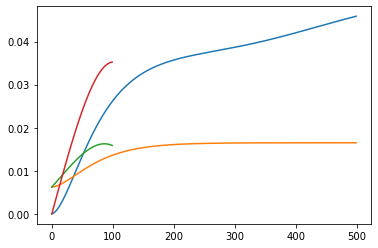

-0.06551319542933311


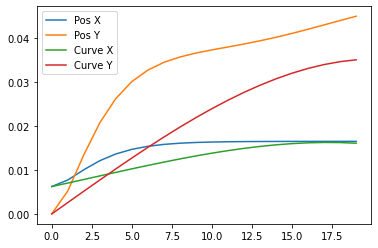

In [47]:
dmp = DMP()
dmp.set_task_params(start[0], goal[0], 5, 0.01)
pos_x = dmp.fwd_simulate(500, 10*np.array([1,1,1,1,1]))
dmp.set_task_params(start[1], goal[1], 5, 0.01)
print(f"Start: {start[1]}, Goal: {goal[1]}")
pos_y = dmp.fwd_simulate(500, 10*np.array([0, 1, 1, 4, 7]))

plt.plot(pos_y)
plt.plot(pos_x)
plt.plot(curve[0])
plt.plot(curve[1])
plt.show()

# pos_x2 =  signal.resample(pos_x, 20)
# pos_y2 =  signal.resample(pos_y, 20)
# curve_x = signal.resample(curve[0], 20)
# curve_y = signal.resample(curve[1], 20)
pos_x2 = pos_x[::len(pos_x)//20]
pos_y2 = pos_y[::len(pos_y)//20]
curve_x = curve[0][::len(curve[0])//20]
curve_y = curve[1][::len(curve[1])//20]

reward = -(np.linalg.norm(pos_x2 - curve_x) + np.linalg.norm(pos_y2 - curve_y))
print(reward)
plt.plot(pos_x2, label="Pos X")
plt.plot(pos_y2, label="Pos Y")
plt.plot(curve_x, label="Curve X")
plt.plot(curve_y, label="Curve Y")
plt.legend()

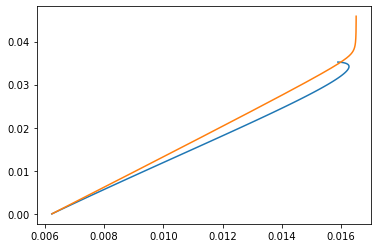

In [48]:
plt.plot(curve[0], curve[1])
_ = plt.plot(pos_x, pos_y)

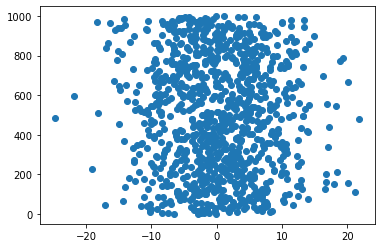

In [49]:
# Test Gaussian Normalization
x = np.random.normal(0, 0.35, 1000)
y = np.arange(1000)
x = x*20
plt.scatter(x,y)

In [50]:
class Env():
    def __init__(self, start, goal, reference, n_bfs = 5):
        curve_x = reference[0][::len(reference[0])//20]
        curve_y = reference[1][::len(reference[1])//20]
        self.reference = [curve_x, curve_y]
        self.start = start
        self.goal = goal
        self.n_bfs = n_bfs
        self.dmp_x = DMP(n_bfs)
        self.dmp_x.set_task_params(start[0], goal[0], 5, 0.01)
        self.dmp_y = DMP(n_bfs)
        self.dmp_y.set_task_params(start[1], goal[1], 5, 0.01)
        self.return_vars = {"observation": None, "reward": None, "done": None, "info": {"is_solved": False}}
        self.a = 0
        
    def step(self, weights):
        pos_x = self.dmp_x.fwd_simulate(500, 20*np.array(weights[:self.n_bfs]))
        pos_y = self.dmp_y.fwd_simulate(500, 20*np.array(weights[self.n_bfs:]))
        
        pos_x2 = pos_x[::len(pos_x)//20]
        pos_y2 = pos_y[::len(pos_y)//20]
        
        reward = -100 * (np.linalg.norm(pos_x2 - self.reference[0]) + np.linalg.norm(pos_y2 - self.reference[1]))

        print(reward)
        # plt.plot(pos_x2, label="Pos X")
        # plt.plot(pos_y2, label="Pos Y")
        # plt.plot(self.reference[0], label="Curve X")
        # plt.plot(self.reference[1], label="Curve Y")

        done = False
        if abs(reward) < 2:
            plt.plot(pos_x2, pos_y2, label="Pos X")
            plt.plot(self.reference[0], self.reference[1], label="Curve X")
            plt.legend()
            plt.show()
            reward = 10
            done = True
        self.a += 1
        return None, reward, done, {"is_solved": done}
    
    def reset(self):
        self.dmp_x.set_task_params(self.start[0], self.goal[0], 5, 0.01)
        self.dmp_y.set_task_params(self.start[1], self.goal[1], 5, 0.01)
        return
    def context(self):
        # Some random function of no significance. But don't remove it!! Needed for REPS
        return None
    def store_trajectory(self):
        # Another random function of no significance. But don't remove it!! Needed for REPS
        return 

REPS attempt 1 of 5: 
policy_params_mean_init_this_attempt:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
policy_params_var_init_this_attempt:
[[0.35 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.35 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.35 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.35 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.35 0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.35 0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.35 0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.35 0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   

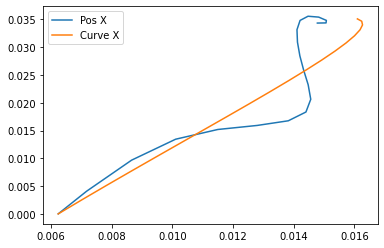

-1.9597671271606312


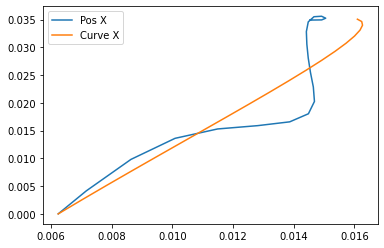

-2.2162905752222635
-1.9823460257153134


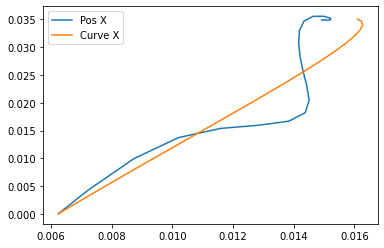

-2.262330337593861
-2.084051719032159
-2.0214663807471314
-2.046442685604354
Rewards for this policy: 1.5114604150504654 +- 5.557469485998821 (1 stdev, n=10)
Solved success rate: 0.3 (3/10)

New policy param mean:
[-1.75567966 -4.64805772  3.48861657 -2.56452327 -1.36301953 -1.2741354
 -2.05571589  2.14022105 -2.64974175 -2.66653951  0.71616032 -4.32953286
 -5.88223246 -1.22615004 -1.10638252  0.24348649  1.95444473 -1.71602625
  0.3526985   0.24821002]
New policy param var diag:
[0.0440831  0.00556627 0.024342   0.05436275 0.02593535 0.08551641
 0.07872219 0.02671745 0.1229412  0.03597587 0.03499947 0.01424022
 0.01536775 0.01041507 0.0234985  0.01821373 0.00884046 0.03406086
 0.02261835 0.02126471]

-1.9763550640339385


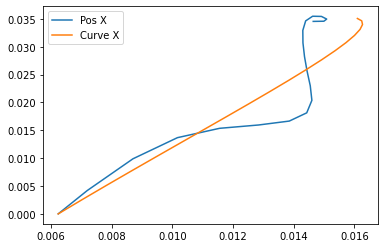

-2.108013568383005
-1.9886234340720856


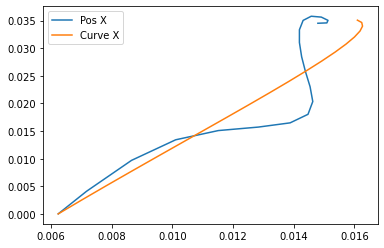

-1.865683290087581


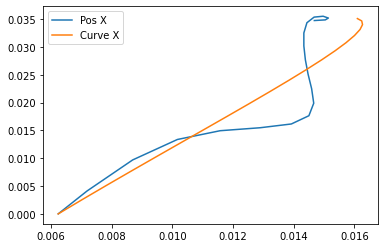

-1.8389095160898843


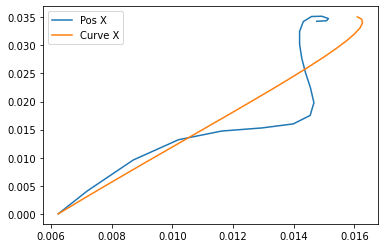

-2.127408003467436
-2.0159524323798705
-1.9985420880869302


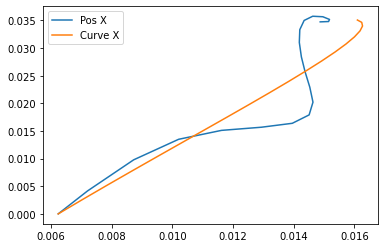

-2.0112745893805504
-1.9548223765876425


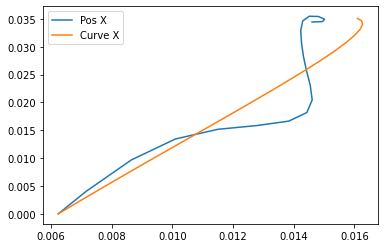

Rewards for this policy: 5.173735140638914 +- 5.911036479724945 (1 stdev, n=10)
Solved success rate: 0.6 (6/10)

New policy param mean:
[-1.74813494 -4.61091985  3.66921949 -2.58771257 -1.36168561 -1.29445023
 -1.99394002  2.18428711 -2.77189541 -2.62811532  0.6824088  -4.45587472
 -5.9777559  -1.31172166 -1.1687977   0.22012434  1.95119444 -1.7474926
  0.27485592  0.1466182 ]
New policy param var diag:
[0.0140835  0.00429475 0.03246051 0.02185572 0.01221567 0.04563492
 0.0758916  0.02449816 0.06245433 0.02136818 0.01047674 0.01488316
 0.00634451 0.00249388 0.01062738 0.02908889 0.00521499 0.01372586
 0.00600083 0.02903197]

-1.937901882672432


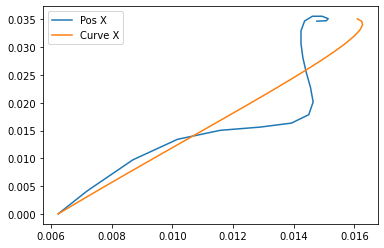

-2.0005656553973017
-1.9960764191825269


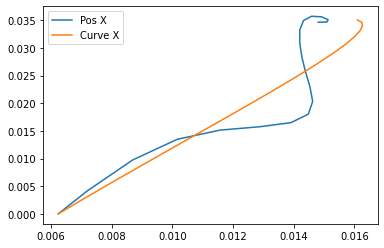

-1.9825693615624438


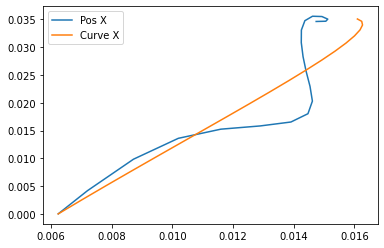

-1.9099325608805542


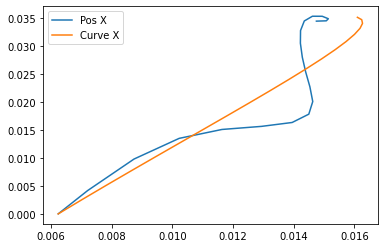

-1.9494859309134434


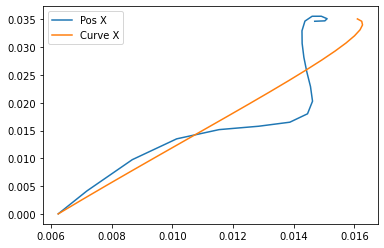

-2.0589950910189248
-1.9035945021172698


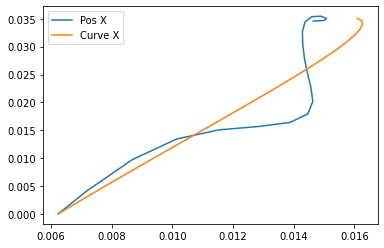

-1.8215636811188582


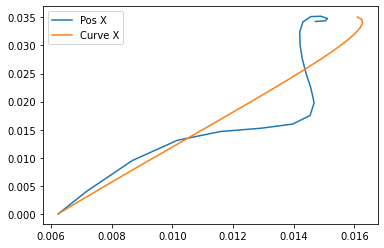

-1.8585040160659383


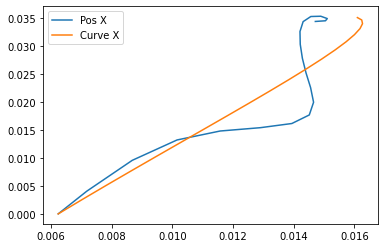

Rewards for this policy: 7.594043925358378 +- 4.811929886476637 (1 stdev, n=10)
Solved success rate: 0.8 (8/10)

New policy param mean:
[-1.73979043 -4.59386912  3.6955001  -2.61572121 -1.36102063 -1.29916282
 -2.00360605  2.20340181 -2.77801562 -2.63312865  0.69258003 -4.4915574
 -5.97879722 -1.32595096 -1.18875359  0.19733752  1.92474094 -1.71732331
  0.27895054  0.08410491]
New policy param var diag:
[0.00901352 0.00145167 0.00800305 0.00671468 0.00613427 0.01589383
 0.02737926 0.01864125 0.02450209 0.00495896 0.00781207 0.00929707
 0.0004411  0.00224481 0.00438548 0.01501742 0.00117452 0.00217976
 0.00281026 0.00988316]

-2.0272771286565487
-1.9438227579288165


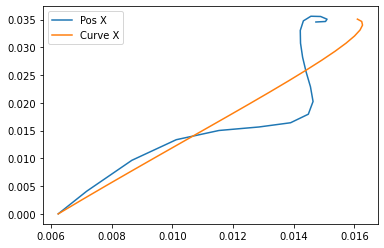

-1.787781567987691


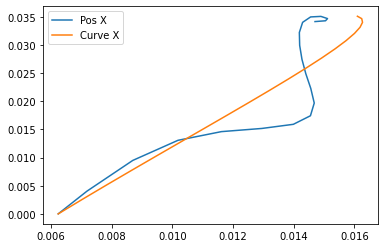

-1.8229937183807332


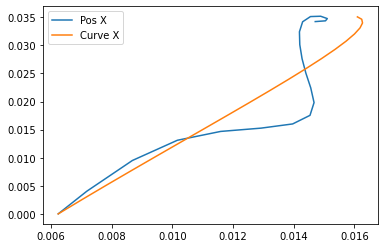

-1.983444084393723


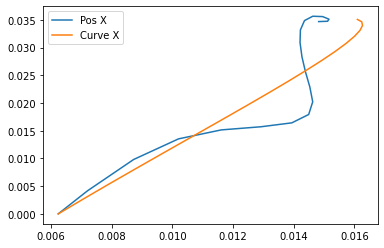

-1.9452543224087466


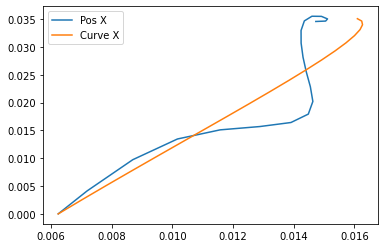

-1.9953341887377136


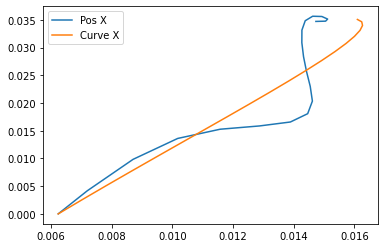

-1.9078691121680476


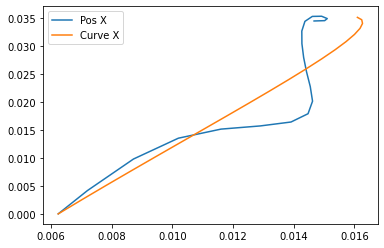

-1.913480510474393


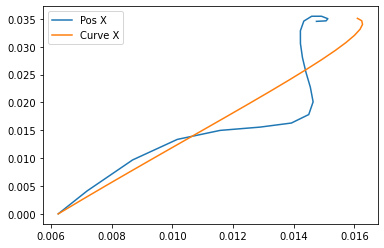

-1.9129271626516946


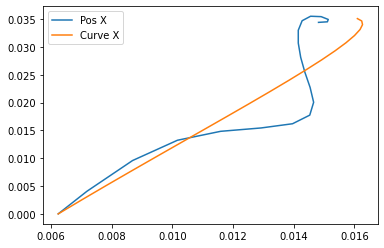

Rewards for this policy: 8.797272287134344 +- 3.6081831385969645 (1 stdev, n=10)
Solved success rate: 0.9 (9/10)
 -> Environment solved fraction has converged.



In [51]:
""" Train a REPS model to match the GT Trajecotry """
from rl_util.identity_policy import IdentityLowLevelPolicy
from rl_util import env_interaction


policy = IdentityLowLevelPolicy(20)
mu = np.zeros(20)
sigma = 0.35

max_num_reps_attempts = 5
max_reps_param_updates = 20

num_policy_rollouts_before_reps_update = 5 * policy.num_params()
env_convergence_criteria = {"env_solved": 0.9}

# Set default Mean and Variance for policy
policy_params_mean_init = np.zeros(policy.num_params()) + mu
policy_params_var_init = np.eye(policy.num_params()) * sigma

curve = pickle.load(open("../data/trajs/curve.pkl",'rb'))
start = (curve[0][0], curve[1][0])
goal = (curve[0][-1], curve[1][-1])
env = Env(start, goal, curve, 10)

reps_converged, low_level_policy_params_mean, \
    low_level_policy_params_var, solve_env_info = \
            env_interaction.solve_env_using_reps(env,
                                policy, policy_params_mean_init,
                                policy_params_var_init, num_policy_rollouts_before_reps_update,
                                max_reps_param_updates, env_convergence_criteria,
                                max_num_reps_attempts=max_num_reps_attempts, debug_info=True, verbose=True,)

reps_policy = {'reps_converged': reps_converged,
            'low_level_policy_params_mean': low_level_policy_params_mean,
            'low_level_policy_params_var': low_level_policy_params_var,
            'solve_env_info': solve_env_info}

In [52]:
reps_policy

{'reps_converged': True,
 'low_level_policy_params_mean': array([-1.73979043, -4.59386912,  3.6955001 , -2.61572121, -1.36102063,
        -1.29916282, -2.00360605,  2.20340181, -2.77801562, -2.63312865,
         0.69258003, -4.4915574 , -5.97879722, -1.32595096, -1.18875359,
         0.19733752,  1.92474094, -1.71732331,  0.27895054,  0.08410491]),
 'low_level_policy_params_var': array([[ 9.01352048e-03, -1.08469465e-03,  2.50456743e-04,
         -6.50883063e-03,  6.95146245e-03, -9.69486875e-03,
          1.45051843e-02, -1.05544432e-02,  9.32759036e-03,
          5.63694928e-03,  8.01205542e-03,  1.78281109e-03,
          1.32083522e-03, -1.34123558e-04,  5.13708679e-03,
          7.01116112e-03, -2.32405200e-03, -2.74710816e-03,
          2.88985507e-03,  6.04494432e-03],
        [-1.08469465e-03,  1.45167351e-03,  3.41093510e-04,
          2.12081915e-04, -8.19962982e-04,  2.06973637e-03,
         -3.65774413e-03,  4.06185836e-03, -5.12667974e-03,
         -7.92326264e-04, -8.00344